<div style="text-align:center"><span style="color:purple; font-family:helvetica; font-size:2.0em;">Bipedal Locomotion Control based on Divergent Component of Motion(DCM)</span></div>

<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:1.7em;">Importing the required libraries</span></div>

In [1]:
#In the following we import the classes that we need for simulation
import time
import pybullet as p#pybullet simulator
import pybullet_data
import numpy as np # numpy library for matrix computatios
from DCMTrajectoryGenerator import * #  DCM trajectory generation Class(will be implemented by students)
from FootTrajectoryRecovery import * # Foot trajectory generation Class
from RobotUtils import * # Class related to Inverse Kinematics 

from qpsolvers import solve_qp
from scipy.spatial.transform import Rotation as R #To calculate rotation matrix

<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:1.7em;">First Part: A toy example for DCM and CoM motion planing</span></div>

c:\Users\Bosstala\.conda\envs\lr24\Lib\site-packages\qpsolvers\conversions\ensure_sparse_matrices.py:24: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
c:\Users\Bosstala\.conda\envs\lr24\Lib\site-packages\qpsolvers\conversions\ensure_sparse_matrices.py:24: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
c:\Users\Bosstala\.conda\envs\lr24\Lib\site-packages\qpsolvers\conversions\ensure_sparse_matrices.py:24: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


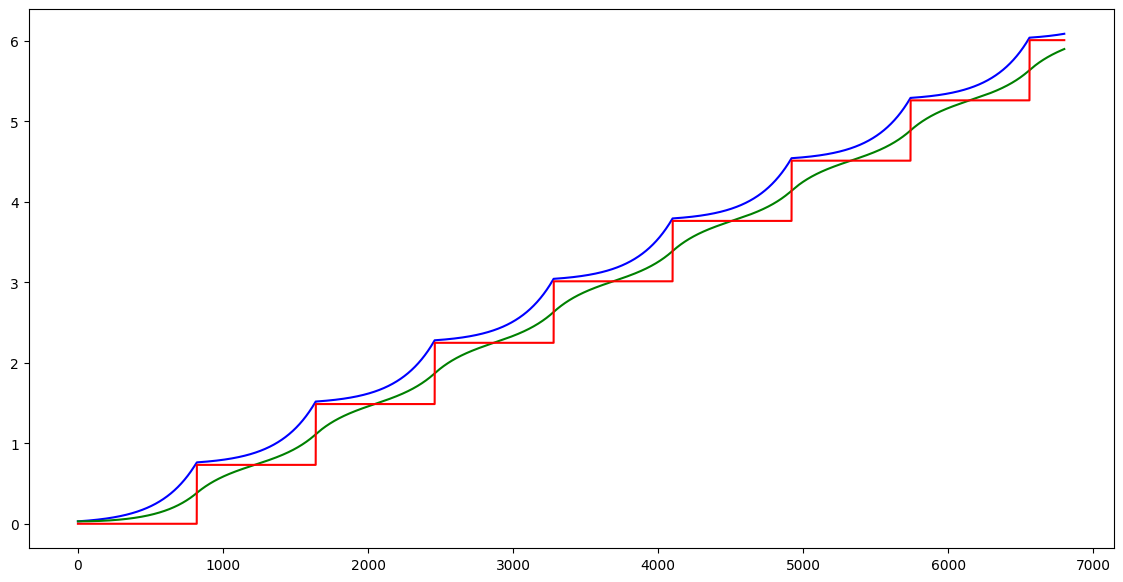

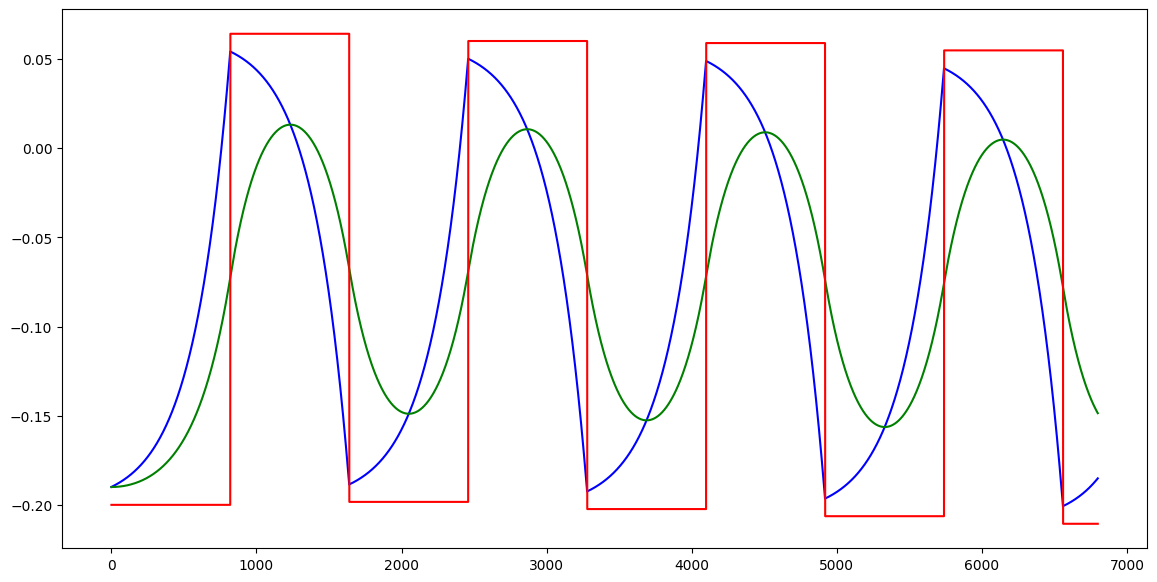

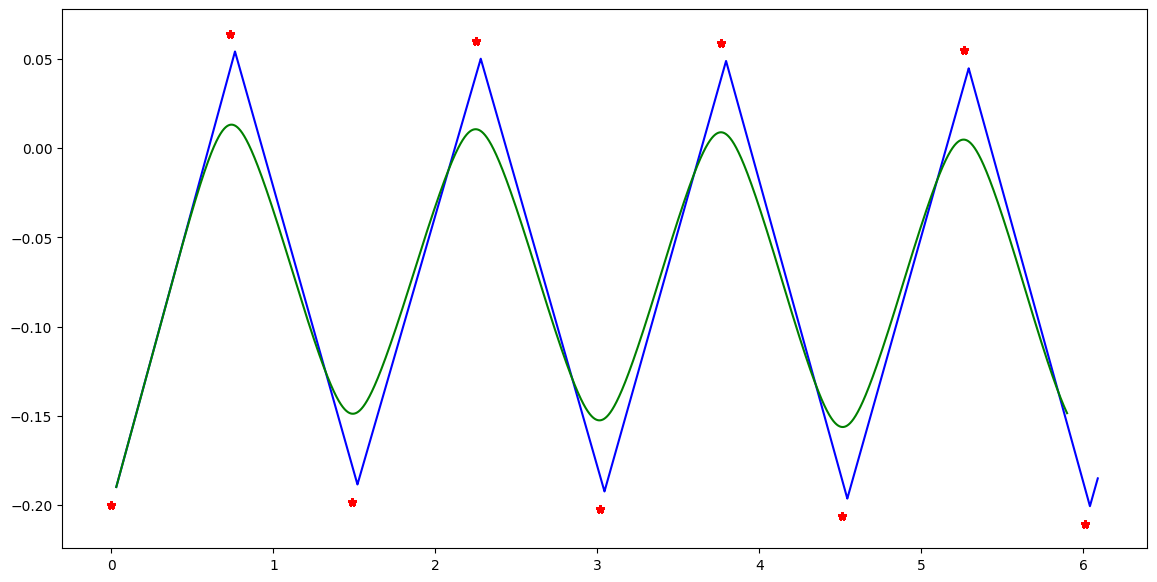

In [2]:
# todo: First start to fill and complete the DCMTrajectoryGenerator based on equation (3) and (9) of the project description
#then continue with the following part
NominalStepWidth=0.2#Nominal lateralDistanceOfFeet/2
NominalStepLength=0.4 # Nominal longitudinal distance between two sequential feet 
NominalStepDuration = 0.82# Nominal step duration 
CoMHeight=0.63 #constant center of mas height

dt_toy=0.001 # time step
DCMx=0.03 #initial DCM position in x direction
DCMy=-NominalStepWidth+0.01 #initial DCM position in y direction
CoPX=0.0 #initial CoP position in X direction
CoPY=-NominalStepWidth #initial CoP position in y direction

#create some lists for collecting data and plotting
DCMTrajectoryToy = list("")
CoMTrajectoryToy = list("")
CoPTrajectoryToy = list("")
ControlInputsToy = list("")

 
DCMGenerator = DCMTrajectoryGenerator(CoMHeight) # todo: #We create an object of DCMTrajectoryGenerator Class
DCMGenerator.initialDCM = np.array([DCMx ,DCMy])
DCMGenerator.timeStep = dt_toy
DCMGenerator.CoM = np.array([DCMx ,DCMy])

stepNumber=0
sign=1 #for switching between right and left leg, could +1 for left foot in swing and or -1 if right foot is in swing
internalStep=0.0

deltaStepDurationMin= 0.3 # we substract this value from nominal step duration to find lower boundry of step duration constraint
deltaStepDurationMax= 1.3 # we add this value to nominal step duration to find upper boundry of step duration constraint

for iter in range(6800):
    alphaCoPX = 1.0
    alphaCoPY = 1.0
    alphaSigma = 1.0
    alphaOffsetX = 1000
    alphaOffsetY = 1000
    
    #CoP Nominal
    CoPNoMX = NominalStepLength + CoPX #CoPX is added here to add previous step position to the nominal step length
    CoPNoMY = sign*NominalStepWidth  #sign parameters switches between right and left foot
    
    OffsetNoMX = 0.03 #nominal DCM x offset
    OffsetNoMY = -1*sign*0.01 #nominal DCM  y offset
    SigmaNoM = math.exp(DCMGenerator.omega * NominalStepDuration) # todo: #nominal sigma (function of NominalStepDuration)

    #make a boundry limit for the next step position and duration 
    CoPTMaxX = CoPNoMX+0.4 #next step position maximum constraits for x
    CoPTMaxY = CoPNoMY+0.4 #next step position maximum constraits for y
    
    CoPTMinX = CoPNoMX-0.4 #next step position minimum constrait for x
    CoPTMinY = CoPNoMY-0.4 #next step position minimum constrait for y
    
    SigmaMin = math.exp(DCMGenerator.omega * (NominalStepDuration - deltaStepDurationMin)) # todo: use NominalStepDuration and deltaStepDurationMin
    SigmaMax = math.exp(DCMGenerator.omega * (NominalStepDuration + deltaStepDurationMax)) # todo: use NominalStepDuration and deltaStepDurationMax
        
    CopXInit = CoPX
    DCMXInit = DCMx
    CopYInit = CoPY
    DCMYInit = DCMy

    DCMGenerator.CoP = np.array([CoPX ,CoPY]) #update the initial CoP position in the DCMTrajectoryGenerator
    
    #make Hessian, Gradient and Constraints matrix of QP based on equations 13,14,15 and 16, 
    #you can expand these equations to find the follwoing matrices 
    P = np.array([
        [alphaCoPX, 0, 0, 0, 0],
        [0, alphaCoPY, 0, 0, 0],
        [0, 0, alphaSigma, 0, 0],
        [0, 0, 0, alphaOffsetX, 0],
        [0, 0, 0, 0, alphaOffsetY]
    ])

    # Create the q vector
    q = np.array([
        -alphaCoPX * CoPNoMX,
        -alphaCoPY * CoPNoMY,
        -alphaSigma * SigmaNoM,
        -alphaOffsetX * OffsetNoMX,
        -alphaOffsetY * OffsetNoMY
    ])
    
    I2 = np.eye(2)
    I1 = np.eye(1)
    
    G = np.block([
        [ I2, np.zeros((2, 1)), np.zeros((2, 2))],
        [-I2, np.zeros((2, 1)), np.zeros((2, 2))],
        [np.zeros((1, 2)), I1, np.zeros((1, 2))],
        [np.zeros((1, 2)), -I1, np.zeros((1, 2))]
    ])
    
    h = np.array([CoPTMaxX,CoPTMaxY,-CoPTMinX,-CoPTMinY,SigmaMax, -SigmaMin]) # todo: use equation 15 and 16 to find the G and h
    
    A = np.array([[1, 0, CopXInit - DCMXInit, 1, 0],[0, 1, CopYInit - DCMYInit, 0, 1]])# todo: use equation 13 and 16 to find the A and b 
    b = np.array([CopXInit, CopYInit]) # todo: use equation 13 and 16 to find the A and b 
    
    #solve QP problem U is the vector of optimized parameters
    U = solve_qp(P, q, G, h, A, b, solver="osqp")
    
    if U is not None:
        stepDuration =  math.log(U[2])/DCMGenerator.omega #todo: find the step duration based on the the optimized sigma (use Log function to find step duration)
    
        DesiredDCM = DCMGenerator.getDCMTrajectory(dt_toy)  #get the desired DCM for the next time-step 
        DesiredCoM = DCMGenerator.getCoM() #get the desired CoM for the next time-step  
            
        DCMGenerator.initialDCM = np.array([DesiredDCM[0] ,DesiredDCM[1]])#set the current DCM position ad next initial dcm position 
        
        DCMTrajectoryToy.append(DesiredDCM)
        CoMTrajectoryToy.append(DesiredCoM)
        CoPTrajectoryToy.append(np.array([CoPX,CoPY]))
        ControlInputsToy.append(U)
        
        internalStep = internalStep+1 #is used for resetting the step parameters
        
        #resetting step parameters when step duration is finished
        if(dt_toy*internalStep>stepDuration):
            stepNumber=stepNumber+1
            internalStep=0
            DCMGenerator.CoP= np.array([U[0] ,U[1]])

            sign=sign*-1

            CoPX =U[0]
            CoPY =U[1]
            
            DCMx =DesiredDCM[0]
            DCMy =DesiredDCM[1]
    else:
        print("U:",U)
        print(iter,"simulation system has no solutions")
        
  
# todo: uncomment to plot         
figg, (ax) = plt.subplots(figsize = (14, 7))
ax.plot(np.array(DCMTrajectoryToy)[:,0],'b',label="DCM")
ax.plot(np.array(CoMTrajectoryToy)[:,0],'g',label="CoM")
ax.plot(np.array(CoPTrajectoryToy)[:,0],'r',label="Cop")
plt.show() 

figg1, (ax1) = plt.subplots(figsize = (14, 7))
ax1.plot(np.array(DCMTrajectoryToy)[:,1],'b',label="DCM")
ax1.plot(np.array(CoMTrajectoryToy)[:,1],'g',label="CoM")
ax1.plot(np.array(CoPTrajectoryToy)[:,1],'r',label="Cop")
plt.show() 

figg2, (ax2) = plt.subplots(figsize = (14, 7))
ax2.plot(np.array(DCMTrajectoryToy)[:,0],np.array(DCMTrajectoryToy)[:,1],'b',label="DCM")
ax2.plot(np.array(CoMTrajectoryToy)[:,0],np.array(CoMTrajectoryToy)[:,1],'g',label="CoM")
ax2.plot(np.array(CoPTrajectoryToy)[:,0],np.array(CoPTrajectoryToy)[:,1],'*r',label="CoP")
plt.show() 


<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:2.37em;">Second Part: Push Recovery During Walking </span></div>

<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:1.7em;">Preparing Pybullet environment</span></div>

In [3]:
#In the following we create an object of dynamic engine of pybullet and we connect it to the Pybullet GUI
phisycsClient = p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())

In [4]:
#In the following we load the urdf model of the robot and we specify the setting for the simulation
p.resetSimulation()
planeID = p.loadURDF("plane.urdf")
p.configureDebugVisualizer(p.COV_ENABLE_RENDERING,0)
p.setGravity(0,0,-9.81)
p.configureDebugVisualizer(p.COV_ENABLE_RGB_BUFFER_PREVIEW,0)
p.configureDebugVisualizer(p.COV_ENABLE_DEPTH_BUFFER_PREVIEW,0)
p.configureDebugVisualizer(p.COV_ENABLE_SEGMENTATION_MARK_PREVIEW,0)
p.configureDebugVisualizer(p.COV_ENABLE_VR_RENDER_CONTROLLERS,0)
p.configureDebugVisualizer(p.COV_ENABLE_Y_AXIS_UP,0)
p.configureDebugVisualizer(p.COV_ENABLE_VR_PICKING,0)
p.configureDebugVisualizer(p.COV_ENABLE_VR_TELEPORTING,0)
p.configureDebugVisualizer(p.COV_ENABLE_WIREFRAME,0)
p.configureDebugVisualizer(p.COV_ENABLE_GUI,0) 
p.configureDebugVisualizer(p.COV_ENABLE_RENDERING,1)
atlas=robotID = p.loadURDF("atlas/atlas_v4_with_multisense.urdf", [0,0,0.93],useFixedBase = 0)
p.setPhysicsEngineParameter()
p.setRealTimeSimulation(0)


<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:1.7em;"Locomotion Planning based on DCM</span></div>

<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:1.7em;">Initialization of the Robot</span></div>


In [5]:
AtlasUtils = RobotUtils()#This object is responsible for inverse kinematics
CoMHeight=0.63 #Constant pelvis(CoM) height
stepWidth=0.3#=lateralDistanceOfFeet/2
stepLength=0.57 #longitudinal distance between two sequential feet stepLength=stepStride/2, 
stepDuration = 0.43
dt=1.0/240.0

#Preparing the constant joints position for the upper-body joints
bodyPositions = [0.0,0.0,0.0,0.0]
leftArmIndex = [3,4,5,6,7,8,9]
rightArmIndex= [11,12,13,14,15,16,17]
bodyIndex = [0,1,2,10]
leftLegIndex=[18,19,20,21,22,23]
rightLegIndex=[24,25,26,27,28,29]
jointsIndex= np.zeros(30)
jointsPositions= np.zeros(30)
jointsIndex[0:4]=bodyIndex
jointsIndex[4:11]=rightArmIndex
jointsIndex[11:18]=leftArmIndex
jointsIndex[18:24]=rightLegIndex
jointsIndex[24:30]=leftLegIndex
jointsPositions[0:4]=bodyPositions


NominalStepWidth=0.1#Nominal lateralDistanceOfFeet/2
NominalStepLength=0.5 # Nominal longitudinal distance between two sequential feet 
NominalStepDuration = 0.4 #todo tune Nominal step duration to find a value that push reovery works

stepWidth = NominalStepWidth
stepLength = NominalStepLength 
stepDuration = NominalStepDuration


for i in range(int(3/dt)):  #1000 sampling time will be allocated for the initialization of the robot position
    #Solving the inverse kinematic and sending the joints position command to the robot
    lowerBodyJoints= AtlasUtils.doInverseKinematics([0.0,0.0,0.9 - (i*dt/3)* (0.9-CoMHeight)], np.eye(3),[0.0,stepWidth,0.0], np.eye(3),[0.0, -stepWidth,0.0], np.eye(3))
    jointsPositions[24:30] =lowerBodyJoints[6:12]
    jointsPositions[18:24] = lowerBodyJoints[0:6]
    
    p.setJointMotorControlArray(bodyIndex=robotID,
                                jointIndices=jointsIndex.astype(int),
                                controlMode=p.POSITION_CONTROL,
                                targetPositions = jointsPositions)

    p.stepSimulation()
    time.sleep(0.0002)
for i in range(20):  #just keep robot at constant CoM height for a few timestep
    lowerBodyJoints= AtlasUtils.doInverseKinematics([0.0,0.0,CoMHeight], np.eye(3),[0.0,stepWidth,0.0], np.eye(3),[0.0, -stepWidth,0.0], np.eye(3))
    jointsPositions[24:30] =lowerBodyJoints[6:12]
    jointsPositions[18:24] = lowerBodyJoints[0:6]
    
    p.setJointMotorControlArray(bodyIndex=robotID,
                                jointIndices=jointsIndex.astype(int),
                                controlMode=p.POSITION_CONTROL,
                                targetPositions = jointsPositions)

    p.stepSimulation()
    time.sleep(0.0002)

<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:1.7em;">Initialization of Parameters</span></div>


In [6]:
# Setting up recording directory
cur_dir = "C:\\Users\\Bosstala\\Documents\\Christian\\EPFL\\MA1\\Legged Robots\\Assignement 2\\Recordings"


DCMGenerator = DCMTrajectoryGenerator(CoMHeight) # todo: We create an object of DCMTrajectoryGenerator Class
# Finding offset based on nominal time duration, Nominal step length and nominalstep width. The idea is that we expect the DCM to have the same offset from the next nominal step location
offsety = 2 * NominalStepWidth / (np.exp(DCMGenerator.omega * NominalStepDuration)+1)
offsetx = 2 * NominalStepLength / (np.exp(DCMGenerator.omega * NominalStepDuration)+1)

# Set initial values for the optimization probelm
AtlasUtils = RobotUtils()
CoMPoS, robotOrn =  p.getBasePositionAndOrientation(robotID) #todo: receive the base position and orientation (use pybullet documentation for finding the related function) 
CoMVel,_ = p.getBaseVelocity(robotID) #todo: receive the base velocity 
DCM0 =  CoMPoS+np.asarray(CoMVel)/math.sqrt(9.81/CoMHeight)  #todo: set DCM position based on CoM position and CoM velocity (assume CoM is on the center of base (pelvis)
CoM0 = np.asarray(CoMPoS)

CoPX=p.getLinkState(robotID,29)[0][0] #initial CoP position in y direction (Right foot position specifies first CoP)
CoPY=p.getLinkState(robotID,29)[0][1] #initial CoP position in y direction 

#uncomment for saving video, there is another line that you also need to uncomment at the end of the code)
curr_recording = p.startStateLogging(p.STATE_LOGGING_VIDEO_MP4,cur_dir + "/Walking"+ ".mp4")

maximumFootHeight = 0.2

#create some lists for collecting data and plotting
DCMTrajectory = list("")
DCMRealTrajectory = list("")
CoMTrajectory = list("")
CoMRealTrajectory = list("")
CoPTrajectory = list("")
ControlInputs = list("")
rightFootTraj_x = list("")
rightFootTraj_y = list("")
leftFootTraj_x = list("")
leftFootTraj_y = list("")
Ux_planned = list("")
Uy_planned = list('')

#Initialize DCM Generator
DCMGenerator.initialDCM = np.array([DCM0[0] + 0.1 ,DCM0[1]]) #initial DCM position in x direction + some offset to initiate the motion
DCMGenerator.timeStep = dt
DCMGenerator.CoM = np.array([CoM0[0] ,CoM0[1]])

leftFootStartPosition = np.empty((1, 3))
leftFootStartPosition[0][:]=[0*NominalStepLength,NominalStepWidth,-0.001]
leftFootFinalPosition = np.empty((1, 3))
rightFootStartPosition = np.empty((1, 3))
rightFootStartPosition[0][:]=[0*NominalStepLength,-NominalStepWidth,-0.001]
rightFootFinalPosition = np.empty((1, 3))
leftFootStartOrientation = np.eye(3)
rightFootStartOrientation = np.eye(3)

stepNumber = 0
sign=1 #for switching between right and left leg, could +1 for left foot in swing and or -1 if right foot is in swing
internalStep = 0.0

deltaStepDurationMin= 0.3 # we substract this value from nominal step duration to find lower boundry of step duration constraint
deltaStepDurationMax= 1.3 # we add this value to nominal step duration to find upper boundry of step duration constraint
NominalStepDuration_prev = NominalStepDuration
time.sleep(1)




<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:1.7em;">Main Control Loop</span></div>


In [ ]:
DBG_LIMITED_STEPS = False
MAX_STEPS = 100
iter = 0
box_exists = False
while True:
   iter += 1

   if iter  > 1/dt and iter  < 1/dt + 23:
      #applying push at the certain period of simulation
      if box_exists == False:
         #add box to apply push on the robot
         gemId = p.loadURDF("boston_box.urdf", [realCoM[0] - 0.78, -0.0, 1.7],  p.getQuaternionFromEuler([0, 0, 0]))
         gemId2 = p.loadURDF("boston_box.urdf", [realCoM[0] - 0.38, -0.3, 1.4],  p.getQuaternionFromEuler([0, 0, 0]))
         box_exists = True
          
      gemPos, gemOrn = p.getBasePositionAndOrientation(gemId)
      force = np.array([873 ,0 ,0])
      p.applyExternalForce(objectUniqueId=gemId, linkIndex=-1,forceObj=force, posObj=gemPos, flags=p.WORLD_FRAME)
      gemPos2, gemOrn2 = p.getBasePositionAndOrientation(gemId2)
      force2 = np.array([0 ,1403 ,0])
      p.applyExternalForce(objectUniqueId=gemId2, linkIndex=-1,forceObj=force2, posObj=gemPos2, flags=p.WORLD_FRAME)

   DesiredDCM =  DCMGenerator.getDCMTrajectory(dt) #todo: get the desired DCM for the next time-step 
   DesiredCoM =  DCMGenerator.getCoM() #todo: get the desired CoM for the next time-step 
   DesiredCoM3d = np.append(DesiredCoM - CoM0[:2] , DCMGenerator.CoMHeight) #make a 3d vector of com position by appending the com height
   realCoM,_ = p.getBasePositionAndOrientation(robotID) #todo: receive the base position and orientation (use pybullet documentation for finding the related function) 
   CoMVel,_ =  p.getBaseVelocity(robotID) #todo: receive the base velocity 
   realDCM =  np.asarray(realCoM) + np.asarray(CoMVel)/math.sqrt(9.81/CoMHeight) #todo: calculate real dcm of the robot

   #We consider for activating push recovery to avoid flunctuation and If DCM error is less than a threshold we will use desired DCM value
   if np.linalg.norm(DesiredDCM - realDCM[:2]) < 0.2:
      currentDCM = DesiredDCM
   else:
      currentDCM = realDCM[:2]

   DCMRealTrajectory.append(currentDCM)
   DCMGenerator.initialDCM = np.array([currentDCM[0],currentDCM[1]]) # Re-initializing the DCM generator with the current values. 

   NominalStepDuration = max(0,NominalStepDuration_prev - internalStep * dt) # Nominal step duration is shrinking  as swing foot is going forward until it touches the ground

   alphaCoPX = 1.0
   alphaCoPY = 1.0
   alphaSigma = 1.0
   alphaOffsetX = 1000
   alphaOffsetY = 1000
   
   #CoP Nominal
   CoPNoMX = NominalStepLength + CoPX #CoPX is added here to add previous step position to the nominal step length
   CoPNoMY = 2 * sign*NominalStepWidth + CoPY #sign parameters switches between right and left foot
   
   OffsetNoMX = offsetx # + 0.05 * (currentDCM[0] - CoPX)#nominal DCM x offset
   OffsetNoMY = -1*sign* offsety #nominal DCM  y offset

   duration_max = NominalStepDuration + deltaStepDurationMax
   duration_min = max(0,NominalStepDuration - deltaStepDurationMin)
   SigmaNoM = math.exp(DCMGenerator.omega * NominalStepDuration) # todo: #nominal sigma (function of NominalStepDuration)  #todo: #nominal sigma (function of NominalStepDuration)

   boundary_limit = 5
   
   #make a boundry limit for the next step position and duration 
   CoPTMaxX = CoPNoMX+boundary_limit #todo next step position maximum constraits for x,  add a value and tune it to have simulation working
   CoPTMaxY = CoPNoMY+boundary_limit  #todo next step position maximum constraits for y, add a value and tune it to have simulation working
   
   CoPTMinX = CoPNoMX-boundary_limit #todo next step position minimum constrait for x, add a value and tune it to have simulation working
   CoPTMinY = CoPNoMY-boundary_limit  #todo next step position minimum constrait for y, add a value and tune it to have simulation working
   
   SigmaMin = math.exp(DCMGenerator.omega * duration_min) #todo: use NominalStepDuration and deltaStepDurationMin
   SigmaMax = math.exp(DCMGenerator.omega * duration_max) #todo: use NominalStepDuration and deltaStepDurationMax

   DCMGenerator.CoP = np.array([CoPX ,CoPY]) #update the initial CoP position in the DCMTrajectoryGenerator
   

    #todo: make Hessian, Gradient and Constraints matrix of QP based on equations 13,14,15 and 16, 
    #you can expand these equations to find the follwoing matrices 
   # todo: use equation 14 and 16 to find the P and Q 
   P = np.array([
        [alphaCoPX, 0, 0, 0, 0],
        [0, alphaCoPY, 0, 0, 0],
        [0, 0, alphaSigma, 0, 0],
        [0, 0, 0, alphaOffsetX, 0],
        [0, 0, 0, 0, alphaOffsetY]
    ])
   q = np.array([
        - alphaCoPX * CoPNoMX,
        - alphaCoPY * CoPNoMY,
        - alphaSigma * SigmaNoM,
        - alphaOffsetX * OffsetNoMX,
        - alphaOffsetY * OffsetNoMY
   ]) 

   # todo: use equation 15 and 16 to find the G and h 
   I2 = np.eye(2)
   I1 = np.eye(1)
   
   G = np.block([
      [ I2, np.zeros((2, 1)), np.zeros((2, 2))],
      [-I2, np.zeros((2, 1)), np.zeros((2, 2))],
      [np.zeros((1, 2)), I1, np.zeros((1, 2))],
      [np.zeros((1, 2)), -I1, np.zeros((1, 2))]
   ])
   h = np.array([CoPTMaxX,CoPTMaxY,-CoPTMinX,-CoPTMinY,SigmaMax, -SigmaMin])

   # todo: use equation 13 and 16 to find the A and b  
   A = np.array([[1, 0, CoPX - currentDCM[0], 1, 0],[0, 1, CoPY - currentDCM[1], 0, 1]])
   b = np.array([CoPX, CoPY])
   
   #solve QP problem U is the vector of optimized parameters
   U = solve_qp(P, q, G, h, A, b, solver="osqp")
   
   Ux_planned.append(U[0])
   Uy_planned.append(U[1])
   stepDuration = np.log(U[2])/DCMGenerator.omega #todo: find the step duration based on the the optimized sigma (use Log function to find step duration)
   
   FootRecovery = FootTrajectoryRecovery((stepDuration + dt * internalStep), maximumFootHeight)
   CoMRealTrajectory.append(np.asarray(realCoM))
    
   if sign ==1:#right foot is in contact with the ground (left is swing foot)
      leftFootFinalPosition[0][:] = np.array([U[0] ,U[1],0.0]).copy()
       
      leftFootPosition = FootRecovery.getSwingFootTrajectory(footPoseStart=leftFootStartPosition,footPoseEnd=leftFootFinalPosition,time=dt*internalStep)
      leftFootOrientation = np.eye(3)
      rightFootPosition = rightFootStartPosition[0].copy()
      rightFootOrientation = rightFootStartOrientation.copy()
       
      rightFootTraj_x.append(rightFootPosition[0])
      rightFootTraj_y.append(rightFootPosition[1])
      leftFootTraj_x.append(leftFootFinalPosition[0][0])
      leftFootTraj_y.append(leftFootFinalPosition[0][1])

   else:#left foot is in contact with the ground   (right is swing foot)
      rightFootFinalPosition[0][:] = np.array([U[0] ,U[1],0.0]).copy()
       
      rightFootPosition = FootRecovery.getSwingFootTrajectory(footPoseStart=rightFootStartPosition,footPoseEnd=rightFootFinalPosition,time=dt*internalStep)
      rightFootOrientation = np.eye(3)
      leftFootPosition = leftFootStartPosition[0].copy()
      leftFootOrientation = leftFootStartOrientation.copy()
       
      rightFootTraj_x.append(rightFootFinalPosition[0][0])
      rightFootTraj_y.append(rightFootFinalPosition[0][1])
      leftFootTraj_x.append(leftFootPosition[0])
      leftFootTraj_y.append(leftFootPosition[1])
   
   lowerBodyJoints = AtlasUtils.doInverseKinematics(DesiredCoM3d, np.eye(3),leftFootPosition, np.eye(3),rightFootPosition, np.eye(3))
   prevLowerbodyJoints = lowerBodyJoints#keep the previous joint position to use in the case of double support
   
   jointsPositions[24:30] = lowerBodyJoints[6:12]
   jointsPositions[18:24] = lowerBodyJoints[0:6]
   
   # apply joint position on the robot (it will automatically implement joint PD)
   p.setJointMotorControlArray(bodyIndex=robotID,
                              jointIndices=jointsIndex.astype(int),
                              controlMode=p.POSITION_CONTROL,
                              targetPositions = jointsPositions)
   p.stepSimulation()
   time.sleep(dt)

   DCMTrajectory.append(DesiredDCM)
   CoMTrajectory.append(DesiredCoM.copy())
   CoPTrajectory.append(np.array([CoPX,CoPY]))
   ControlInputs.append(U)
   
   internalStep = internalStep+1 #is used for resetting the step parameters

   #resetting step parameters when step duration is finished
   if(dt>stepDuration):
      stepNumber=stepNumber+1
      if DBG_LIMITED_STEPS and stepNumber == MAX_STEPS: # Stop after certain number of steps
         break

      internalStep=0
      CoMPoS, robotOrn = p.getBasePositionAndOrientation(robotID) #todo: receive the base position and orientation (use pybullet documentation for finding the related function) 
      CoMVel,_ = p.getBaseVelocity(robotID) #todo: receive the base velocity 
      DCM_step =  CoMPoS + np.asarray(CoMVel)/math.sqrt(9.81/CoMHeight) 
      CoM_step = np.asarray(CoMPoS)
      DCMGenerator.CoM = np.array([CoM_step[0] ,CoM_step[1]])
      
      if sign == 1: #right foot was in contact with the ground (will be used for getting CoP)
         foot_index = 23
      else: #left foot was in contact with the ground (will be used for getting CoP)
         foot_index = 29

      CoPX = p.getLinkState(robotID,foot_index)[0][0] #initial CoP position in X direction
      CoPY = p.getLinkState(robotID,foot_index)[0][1] #initial CoP position in y direction
      CoP_prev = DCMGenerator.CoP.copy()
      DCMGenerator.CoP = np.array([CoPX ,CoPY])

      DCMGenerator.initialDCM = DCM_step[:-1]
      sign = sign*-1

      # Updating the start position of both legs 
      leftFootStartPosition[0][:]  = [p.getLinkState(robotID,23)[0][0], p.getLinkState(robotID,23)[0][1],0]
      rightFootStartPosition[0][:] = [p.getLinkState(robotID,29)[0][0], p.getLinkState(robotID,29)[0][1],0]
      leftFootStartOrientation = R.from_quat(np.asarray(p.getLinkState(robotID,23)[1])).as_matrix()
      rightFootStartOrientation = R.from_quat(np.asarray(p.getLinkState(robotID,29)[1])).as_matrix()

#uncomment for video recording (another part of the code also should be uncommented)         
p.stopStateLogging(curr_recording)


In [8]:
time.sleep(7)
p.disconnect()

error: Not connected to physics server.